In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# 读取数据C:\MyProject\MIMIC-IPE\data\icu_data.csv
data = pd.read_csv('C:/MyProject/MIMIC-IPE/data/icu_data.csv')
# 获取data中的所有列名、列中空值计数和列中空值占比，形成一个新的DataFrame
data_info = pd.DataFrame(data.columns, columns=['column_name'])
data_info['missing_count'] = data.isnull().sum().values
# 将空值占比转换为百分数形式
data_info['missing_rate'] = (data.isnull().sum().values / data.shape[0] * 100).round(2)

In [9]:
# 删除data中所有列名最后两位字符串为“_1”的列
data = data.drop(data.columns[data.columns.str.endswith('_1')], axis=1)
# 删除data中所有列名最后两位字符串为“_2”的列
data = data.drop(data.columns[data.columns.str.endswith('_2')], axis=1)
# 设置subject_id、hadm_id和stay_id为索引
data = data.set_index(['subject_id'])
'''
删除以下列：
hadm_id
stay_id
blood_count_hematocrit
blood_count_hemoglobin
blood_count_mch
blood_count_mchc
blood_count_mcv
blood_count_platelet
blood_count_rbc
blood_count_rdw
blood_count_wbc
coagulation_ptt
'''
data = data.drop(['hadm_id', 'stay_id', 'blood_count_hematocrit', 'blood_count_hemoglobin', 'blood_count_mch',
                  'blood_count_mchc', 'blood_count_mcv', 'blood_count_platelet', 'blood_count_rbc',
                  'blood_count_rdw', 'blood_count_wbc', 'coagulation_ptt'], axis=1)
'''删除以下列：
hospstay_seq
first_hosp_stay
icustay_seq
first_icu_stay
icd_code
icd_version

dischtime
icu_intime
avg_los
'''
data = data.drop(['hospstay_seq', 'first_hosp_stay', 'icustay_seq', 'first_icu_stay', 'icd_code', 'icd_version',
                  'dischtime', 'icu_intime', 'avg_los'], axis=1)
'''提取以下几列，以下几列是待比较的值，形成一个新的dataframe：
hospital_expire_flag
re_inhosp
icu_count
14-days
31-days
los_icu
'''
data_compare = data[['hospital_expire_flag', 're_inhosp', 'icu_count', '14-days', '31-days', 'los_icu']]
# 从data中删除以上列
data = data.drop(['hospital_expire_flag', 're_inhosp', 'icu_count', '14-days', '31-days', 'los_icu'], axis=1)


# data中的gender列使用labelencoder进行编码
from sklearn.preprocessing import LabelEncoder
# Instantiate the LabelEncoder
labelencoder = LabelEncoder()
# Fit and transform the 'gender' column in 'X'
data['gender'] = labelencoder.fit_transform(data['gender'])
# data中的Group_label列使用labelencoder进行编码
# Fit and transform the 'Group_label' column in 'X'
data['Group_Label'] = labelencoder.fit_transform(data['Group_Label'])
# X中的race列使用one-hot编码，然后再将原race列删除，再把one-hot编码后的列加入X
# Perform one-hot encoding on the 'race' column
race_dummies = pd.get_dummies(data['race'], prefix='race')
# Drop the original 'race' column from 'data'
data = data.drop('race', axis=1)
# Concatenate 'data' with the one-hot encoded DataFrame
data = pd.concat([data, race_dummies], axis=1)


In [10]:
# 将日期数据转换为日期时间格式
data['dod'] = pd.to_datetime(data['dod'])
data['admittime'] = pd.to_datetime(data['admittime'])

# 计算观察期内的天数，限制为最多7天
data['observation_days'] = (data['dod'] - data['admittime']).dt.days
data['observation_days'] = data['observation_days'].clip(upper=7)

# 创建事件状态列
# 如果死亡日期存在，并且死亡日期与入院日期的差值小于等于7天，认为事件发生
data['event_status'] = np.where((data['dod'].notnull()) & (data['observation_days'] <= 7), 1, 0)

# 删除不再需要的列
data = data.drop('admittime', axis=1)

In [11]:

# 删除data中缺失值超过10%的列
data = data.drop(data_info[data_info['missing_rate'] > 10]['column_name'], axis=1)
# 获取data中的所有列名、列中空值计数和列中空值占比，形成一个新的DataFrame
data_info = pd.DataFrame(data.columns, columns=['column_name'])
data_info['missing_count'] = data.isnull().sum().values
# 将空值占比转换为百分数形式
data_info['missing_rate'] = (data.isnull().sum().values / data.shape[0] * 100).round(2)

In [12]:
# 将data保存到C:\MyProject\MIMIC-IPE\data\full_dataforcox.csv
data.to_csv('C:/MyProject/MIMIC-IPE/data/icu_dataforcox.csv')

In [58]:
# 使用均值填充data中所有的缺失值
data = data.fillna(data.mean())

Log-rank test between group 1 and group 0: p=0.0062698794658998585


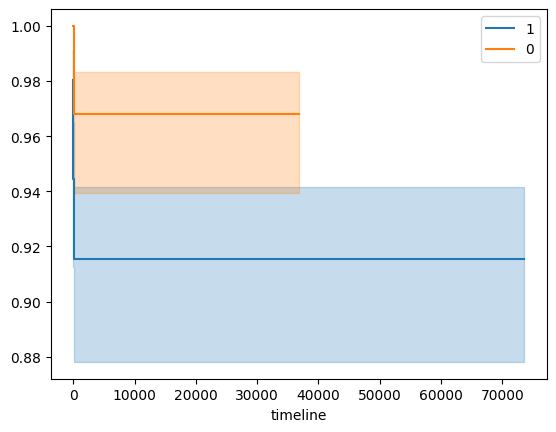

In [59]:
# data中event_status列为事件列，death_day列为时间列，其余列为特征列，Group_Label为分组列，对data进行Kaplan-Meier生存曲线分析，使用log-rank检验，并且画出生存曲线
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Initialize the KaplanMeierFitter class
kmf = KaplanMeierFitter()

# Get the unique groups
groups = data['Group_Label'].unique()

# Perform Kaplan-Meier survival analysis for each group and plot the survival curve
for group in groups:
    group_data = data[data['Group_Label'] == group]
    kmf.fit(group_data['death_day'], group_data['event_status'], label=str(group))
    kmf.plot()

# Perform log-rank test between each pair of groups
for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        group_i_data = data[data['Group_Label'] == groups[i]]
        group_j_data = data[data['Group_Label'] == groups[j]]
        results = logrank_test(group_i_data['death_day'], group_j_data['death_day'],
                               event_observed_A=group_i_data['event_status'], event_observed_B=group_j_data['event_status'])
        print(f'Log-rank test between group {groups[i]} and group {groups[j]}: p={results.p_value}')


In [43]:
import pandas as pd
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.util import Surv

# 假设data已经加载，并且所有类别变量已经转换为数值型（one-hot编码等）
X = data.drop(columns=['7-days', 'death_time'])
y = data[['7-days', 'death_time']]

# 创建生存数据的结构
y_structured = Surv.from_dataframe(event='7-days', time='death_time', data=y)

# 设置Elastic Net模型
model = CoxnetSurvivalAnalysis(l1_ratio=0.5, alpha_min_ratio=0.01, max_iter=100000)

# 训练模型
model.fit(X, y_structured)

# 提取特征的系数
coefficients = model.coef_

# 对特征按重要性排序，并选择前15个
important_features = pd.DataFrame(coefficients.T, index=X.columns, columns=['Coefficients'])
top_features = important_features.abs().sort_values(by='Coefficients', ascending=False).head(15)
print("Top 15 selected features based on Elastic Net:")
print(top_features)


ValueError: event indicator must be binary

In [44]:
# 对data做cox风险回归，其中7-days列为事件列，death_time列为时间列，其余列为特征列
from lifelines import CoxPHFitter

# 初始化CoxPHFitter类
cph = CoxPHFitter()

# 对数据进行Cox风险回归
cph.fit(data, duration_col='death_time', event_col='7-days')

# 打印摘要
cph.print_summary()

C:\Users\ZhouNan\anaconda3\envs\NN\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['race_AMERICAN INDIAN/ALASKA NATIVE', 'race_BLACK/AFRICAN', 'race_BLACK/CAPE VERDEAN', 'race_HISPANIC/LATINO - COLUMBIAN', 'race_HISPANIC/LATINO - DOMINICAN', 'race_HISPANIC/LATINO - GUATEMALAN', 'race_HISPANIC/LATINO - PUERTO RICAN', 'race_MULTIPLE RACE/ETHNICITY', 'race_PATIENT DECLINED TO ANSWER', 'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_UNABLE TO OBTAIN', 'race_WHITE - EASTERN EUROPEAN', 'race_WHITE - OTHER EUROPEAN', 'race_WHITE - RUSSIAN'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\ZhouNan\anaconda3\envs\NN\Lib\site-packages\lifelines\utils\__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (

ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model